### This jupyter notebook is for the deep learning project(Group 20).
### dataset: https://github.com/Hua-YS/AID-Multilabel-Dataset

This is the <strong>experiment</strong> part, after train the BCE, Focal and ASL model, we carry out the experiment here.


## Import required packages

In [4]:
import torchvision.models as models
from torch import nn
import torch
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy
# Imports for calculating metrics
from PIL import *
from sklearn.metrics import f1_score, recall_score, precision_score
import torch.nn.functional as F
from matplotlib.pyplot import imshow

/opt/homebrew/Caskroom/miniforge/base/envs/pytorchlearn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Change to GPU

In [6]:
# It's very important here because we use Mac M1 chip to train so we use 'mps' here
# If you use Nvidia, please use CUDA
device = torch.device('mps')

In [7]:
device

device(type='mps')

## Global Variables

In [8]:
# AID Dataser
## Training set path
training_path = '/Users/huangcheng/Documents/newAIDDataset/images/images_tr/'
## test set path
test_path = '/Users/huangcheng/Documents/newAIDDataset/images/images_test/'
## the number of classes
num_class = 17
## csv path
data_csv = '/Users/huangcheng/Documents/newAIDDataset/newlabelfinal.csv'

## Import CSV Files

In [11]:
cats = pd.read_csv(data_csv, header=None)
cats = list(cats[0])
cats = cats[1:]

In [61]:
data = pd.read_csv(data_csv)
data.head()

IMAGE\LABEL  airplane  bare-soil  buildings  cars  chaparral  court  dock  \
0   airport_1         1          1          1     1          0      0     0   
1   airport_2         1          1          1     1          0      0     0   
2   airport_3         1          0          1     1          0      0     0   
3   airport_4         1          1          1     1          0      0     0   
4   airport_5         1          1          1     1          0      0     0   

   field  grass  mobile-home  pavement  sand  sea  ship  tanks  trees  water  
0      0      1            0         1     0    0     0      0      0      0  
1      0      1            0         1     0    0     0      0      1      0  
2      0      1            0         1     0    0     0      0      0      0  
3      0      1            0         1     0    0     0      0      0      0  
4      0      1            0         1     0    0     0      0      0      0

## Data Transformation

In [19]:
# Transformations on the data
transformations = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

## Visualize the label distribution

[('mobile-home', 2), ('airplane', 99), ('tanks', 108), ('chaparral', 112), ('field', 214), ('sea', 221), ('sand', 259), ('dock', 271), ('ship', 284), ('court', 344), ('water', 852), ('bare-soil', 1475), ('cars', 2026), ('buildings', 2161), ('grass', 2295), ('pavement', 2328), ('trees', 2406)]
There ara total 17 classes


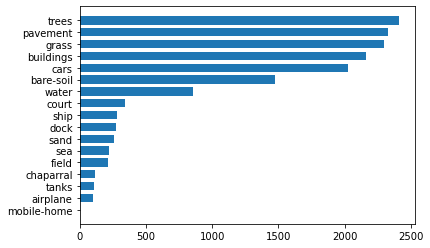

In [15]:
classes= ['airplane', 'bare-soil', 'buildings', 
          'cars', 'chaparral', 'court', 'dock', 
          'field', 'grass', 'mobile-home', 'pavement',
          'sand', 'sea', 'ship', 'tanks', 'trees', 'water']
numbers = []
label_number = {}


for i in range(len(classes)):
  label_number[classes[i]] = data[classes[i]].sum()

# sort according the number of ooucrance for each class
label_number = sorted(label_number.items(), key=lambda item: item[1], reverse=False)
print(label_number)

keys = []
values = []

for key, value in label_number:
  keys.append(key)
  values.append(value)
print("There ara total {} classes".format(len(keys)))

plt.barh(range(len(keys)), values, tick_label = keys, height=0.7)
plt.show()

In [81]:
## class and true label mapping
classes= ['airplane', 'bare-soil', 'buildings', 
          'cars', 'chaparral', 'court', 'dock', 
          'field', 'grass', 'mobile-home', 'pavement',
          'sand', 'sea', 'ship', 'tanks', 'trees', 'water']

## some ramdom picture in the test set to valuate the models in order to write report :)

imgs = ['airport_91', 'bareland_91', 'baseballfield_91', 'beach_91', 'bridge_91',
        'center_91', 'church_91', 'commercial_91', 'denseresidential_91', 'desert_91',
        'farmland_91', 'forest_91', 'industrial_91', 'meadow_91', 'mediumresidential_91',
        'mountain_91', 'park_191', 'parking_91', 'playground_91', 'pond_91',
        'port_91', 'railwaystation_91', 'resort_91', 'river_91', 'school_91',
        'sparseresidential_91', 'square_91', 'stadium_91', 'storagetanks_91', 'viaduct_91']

imgs2 = ['airport_92', 'bareland_92', 'baseballfield_92', 'beach_92', 'bridge_92',
        'center_92', 'church_92', 'commercial_92', 'denseresidential_92', 'desert_92',
        'farmland_92', 'forest_92', 'industrial_92', 'meadow_92', 'mediumresidential_92',
        'mountain_92', 'park_192', 'parking_92', 'playground_92', 'pond_92',
        'port_92', 'railwaystation_92', 'resort_92', 'river_92', 'school_92',
        'sparseresidential_92', 'square_92', 'stadium_91', 'storagetanks_92', 'viaduct_92']

imgs3 = ['airport_93', 'bareland_93', 'baseballfield_93', 'beach_93', 'bridge_93',
        'center_93', 'church_93', 'commercial_93', 'denseresidential_93', 'desert_93',
        'farmland_93', 'forest_93', 'industrial_93', 'meadow_93', 'mediumresidential_93',
        'mountain_93', 'park_193', 'parking_93', 'playground_93', 'pond_93',
        'port_93', 'railwaystation_93', 'resort_93', 'river_93', 'school_93',
        'sparseresidential_93', 'square_93', 'stadium_93', 'storagetanks_93', 'viaduct_93']

labels = pd.read_csv(data_csv)
name_label_dic = {}
labels.iloc[1]
for i in tqdm(range(labels.shape[0])):
  label = []
  for j in range(1, num_class+1):
    label.append(labels.iloc[i][j])
  name_label_dic[labels.iloc[i][0]] = label

100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1854.26it/s]


## Experiment with the BCE model

In [23]:
### Load the BCE model
bce_model = torch.load("/Users/huangcheng/Documents/DeepLearningProjectModels/bce.pth")

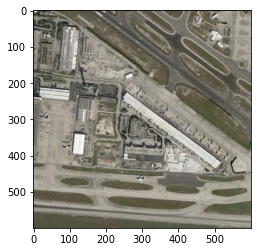

===== airport_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['airplane', 'bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']


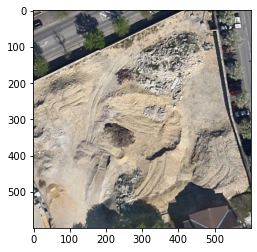

===== bareland_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees', 'water']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'pavement', 'trees']


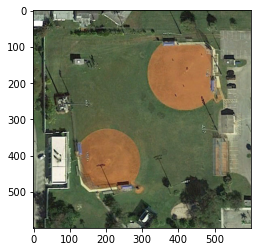

===== baseballfield_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'trees']


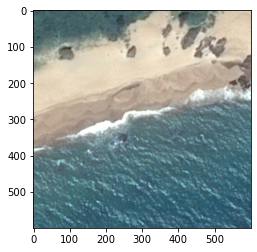

===== beach_91 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
['sand', 'sea', 'water']
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]
['sand', 'sea', 'trees']


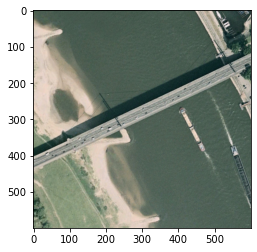

===== bridge_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['buildings', 'cars', 'grass', 'pavement', 'trees', 'water']
True Result:
[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
['bare-soil', 'cars', 'dock', 'grass', 'pavement', 'ship', 'trees', 'water']


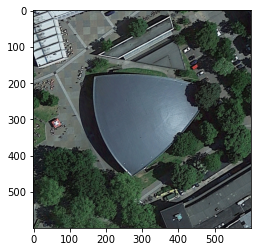

===== center_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']


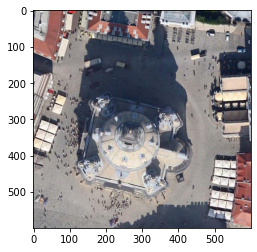

===== church_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']


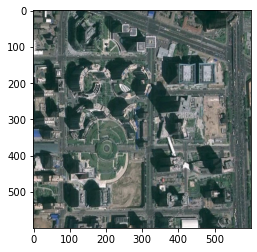

===== commercial_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']


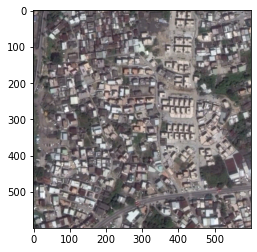

===== denseresidential_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']


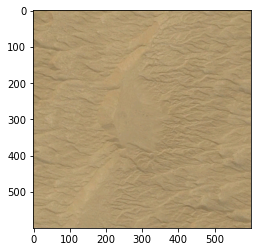

===== desert_91 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
['sand']
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
['sand']


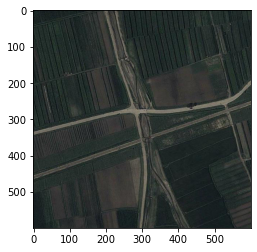

===== farmland_91 =====
Predict Result:
[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'field', 'pavement', 'trees']
True Result:
[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
['bare-soil', 'field', 'pavement']


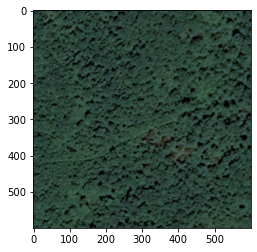

===== forest_91 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[]
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
['trees']


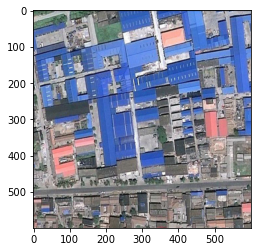

===== industrial_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']


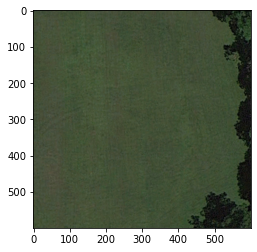

===== meadow_91 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
['grass', 'trees']
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
['grass', 'pavement']


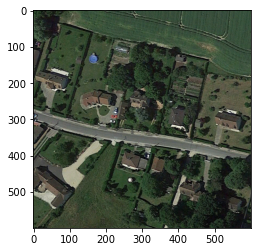

===== mediumresidential_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['buildings', 'cars', 'grass', 'pavement', 'trees', 'water']


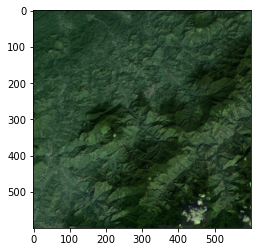

===== mountain_91 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
['grass', 'trees', 'water']
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
['grass', 'trees']


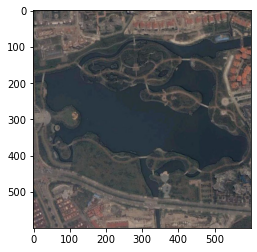

===== park_191 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees', 'water']
True Result:
[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'dock', 'grass', 'pavement', 'ship', 'trees', 'water']


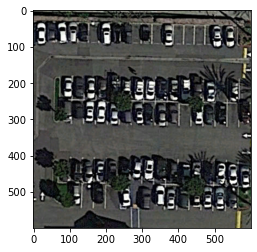

===== parking_91 =====
Predict Result:
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
['cars', 'pavement']
True Result:
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
['cars', 'pavement', 'trees']


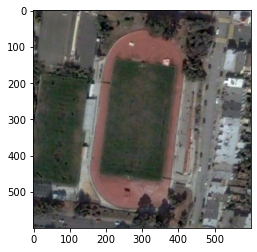

===== playground_91 =====
Predict Result:
[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'court', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'court', 'grass', 'pavement', 'trees']


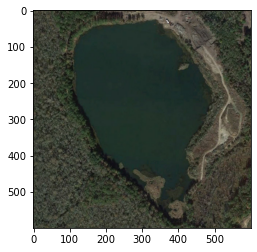

===== pond_91 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
['grass', 'trees', 'water']
True Result:
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
['cars', 'grass', 'trees', 'water']


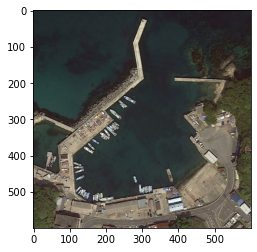

===== port_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0]
['buildings', 'cars', 'dock', 'pavement', 'sea', 'ship', 'trees']


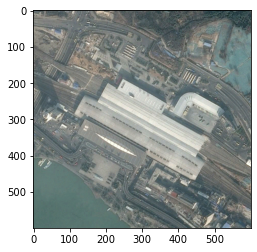

===== railwaystation_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'sea', 'trees']


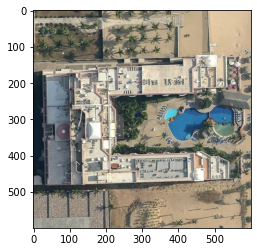

===== resort_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'chaparral', 'grass', 'pavement', 'sand', 'trees', 'water']


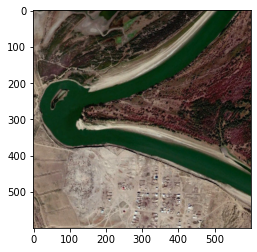

===== river_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees', 'water']
True Result:
[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'chaparral', 'grass', 'trees', 'water']


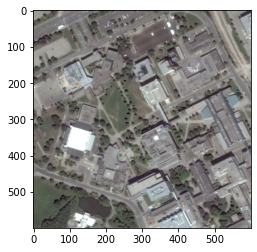

===== school_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['buildings', 'cars', 'grass', 'pavement', 'trees', 'water']


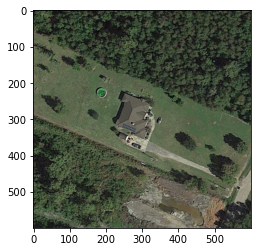

===== sparseresidential_91 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['buildings', 'cars', 'grass', 'pavement', 'trees', 'water']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees', 'water']


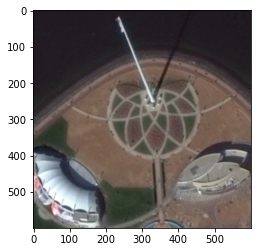

===== square_91 =====
Predict Result:
[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees', 'water']


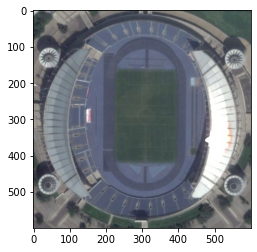

===== stadium_91 =====
Predict Result:
[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'court', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['buildings', 'cars', 'court', 'grass', 'pavement', 'trees', 'water']


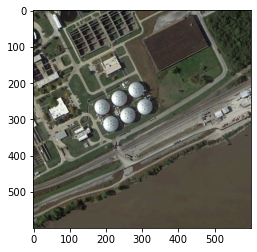

===== storagetanks_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
['bare-soil', 'buildings', 'cars', 'dock', 'grass', 'pavement', 'tanks', 'trees', 'water']


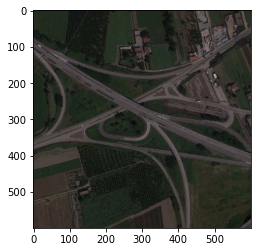

===== viaduct_91 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'field', 'grass', 'pavement', 'trees']


In [75]:
for img in imgs:
    img_path = os.path.join(test_path, "{}.jpg".format(img))
    sample_img = Image.open(img_path).convert('RGB')
    img_tensor = transformations(sample_img)
    img_tensor = img_tensor.reshape(1, 3, 224, 224)
    imshow(sample_img)
    plt.show()

    bce_model.eval()
    with torch.no_grad():
        img_tensor_tensor = img_tensor.to(device)
        outputs = bce_model(img_tensor_tensor)
        outputs = torch.sigmoid(outputs)
        preds_label = np.around(outputs.cpu().detach().numpy())[0].tolist()
        preds_label = [int(val) for val in preds_label]
        print("===== {} =====".format(img))
        print("Predict Result:")
        print(preds_label)
        print([classes[index] for index, item in enumerate(preds_label) if item == 1])
        print("True Result:")
        print(name_label_dic[img])
        print([classes[index] for index, item in enumerate(name_label_dic[img]) if item == 1])

## Experiment with the Focal model

In [5]:
### Load the Focal model
focal_model = torch.load("/Users/huangcheng/Documents/DeepLearningProjectModels/focal.pth")

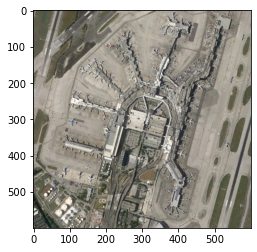

===== airport_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['airplane', 'bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']


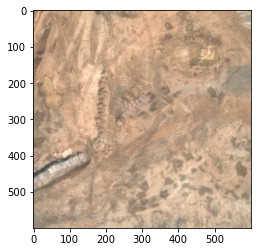

===== bareland_92 =====
Predict Result:
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
['bare-soil', 'grass', 'water']
True Result:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
['bare-soil', 'mobile-home']


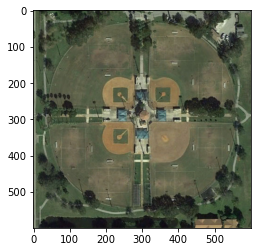

===== baseballfield_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'court', 'grass', 'pavement', 'trees']


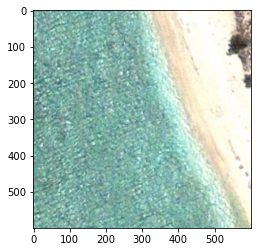

===== beach_92 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
['trees']
True Result:
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
['chaparral', 'sand', 'sea']


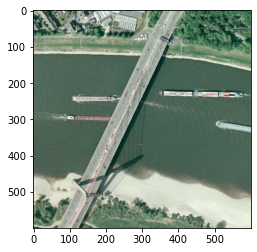

===== bridge_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
['buildings', 'cars', 'dock', 'grass', 'pavement', 'ship', 'trees', 'water']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'ship', 'trees', 'water']


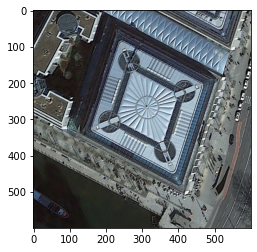

===== center_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'tanks', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]
['buildings', 'cars', 'pavement', 'ship', 'water']


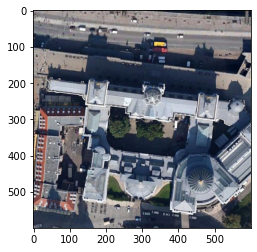

===== church_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']


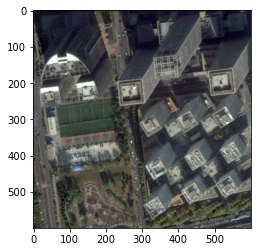

===== commercial_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']


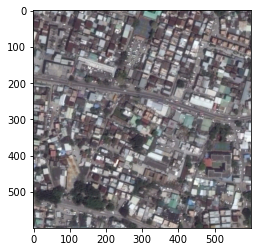

===== denseresidential_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']


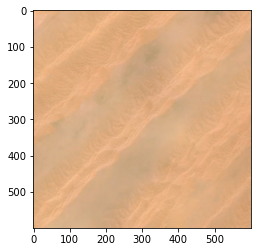

===== desert_92 =====
Predict Result:
[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
['bare-soil', 'field', 'sand', 'water']
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
['sand']


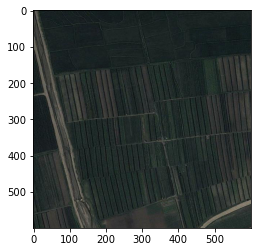

===== farmland_92 =====
Predict Result:
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
['buildings', 'field', 'pavement']
True Result:
[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
['bare-soil', 'field', 'pavement']


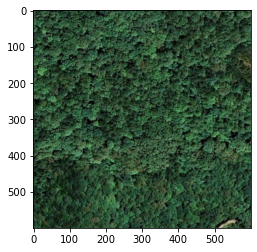

===== forest_92 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
['grass', 'trees']
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
['trees']


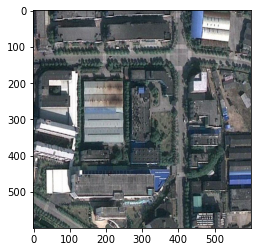

===== industrial_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']


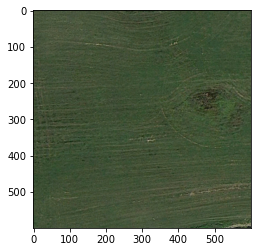

===== meadow_92 =====
Predict Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
['grass', 'pavement']
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
['grass', 'pavement']


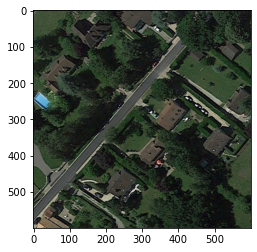

===== mediumresidential_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['buildings', 'cars', 'grass', 'pavement', 'trees', 'water']


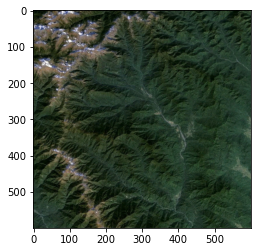

===== mountain_92 =====
Predict Result:
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
['buildings', 'grass', 'trees']
True Result:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
['grass', 'trees']


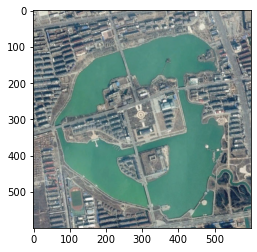

===== park_192 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'dock', 'grass', 'pavement', 'sea', 'ship', 'trees', 'water']
True Result:
[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'court', 'dock', 'grass', 'pavement', 'ship', 'trees', 'water']


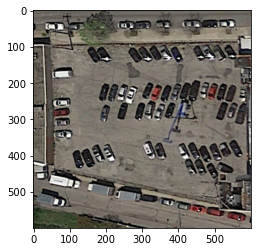

===== parking_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']


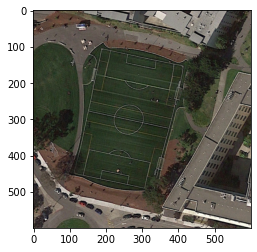

===== playground_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'court', 'grass', 'pavement', 'trees']


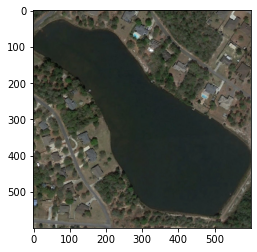

===== pond_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['buildings', 'grass', 'pavement', 'trees', 'water']


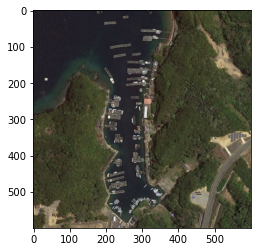

===== port_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees', 'water']
True Result:
[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'dock', 'grass', 'pavement', 'sea', 'ship', 'trees']


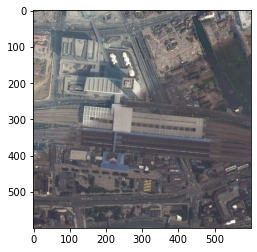

===== railwaystation_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees', 'water']


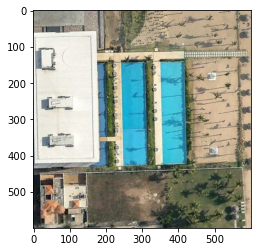

===== resort_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'sand', 'trees', 'water']


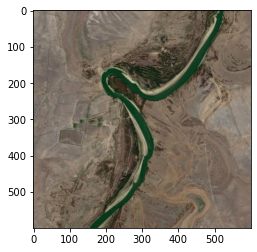

===== river_92 =====
Predict Result:
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
['bare-soil', 'grass', 'trees', 'water']
True Result:
[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]
['bare-soil', 'chaparral', 'field', 'grass', 'trees', 'water']


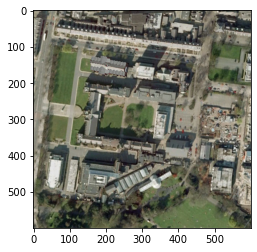

===== school_92 =====
Predict Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['buildings', 'cars', 'grass', 'pavement', 'trees']


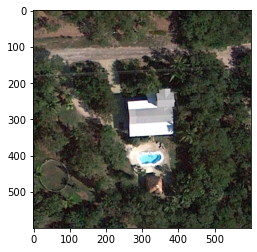

===== sparseresidential_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees', 'water']
True Result:
[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
['bare-soil', 'buildings', 'grass', 'trees', 'water']


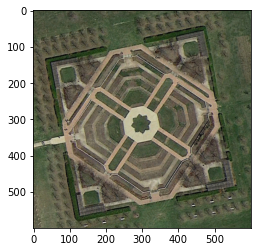

===== square_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'grass', 'pavement', 'trees']


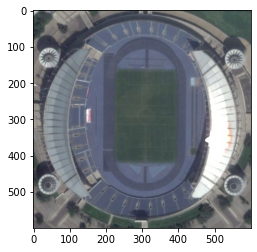

===== stadium_91 =====
Predict Result:
[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'court', 'grass', 'pavement', 'trees']
True Result:
[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
['buildings', 'cars', 'court', 'grass', 'pavement', 'trees', 'water']


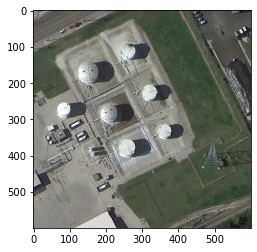

===== storagetanks_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'tanks', 'trees']
True Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'tanks', 'trees']


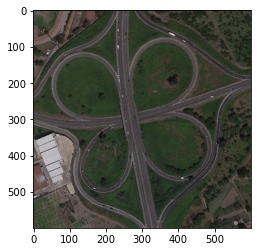

===== viaduct_92 =====
Predict Result:
[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'grass', 'pavement', 'trees']
True Result:
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
['bare-soil', 'buildings', 'cars', 'court', 'field', 'grass', 'pavement', 'trees']


In [83]:
for img in imgs2:
    img_path = os.path.join(test_path, "{}.jpg".format(img))
    sample_img = Image.open(img_path).convert('RGB')
    img_tensor = transformations(sample_img)
    img_tensor = img_tensor.reshape(1, 3, 224, 224)
    imshow(sample_img)
    plt.show()

    focal_model.eval()
    with torch.no_grad():
        img_tensor_tensor = img_tensor.to(device)
        outputs = focal_model(img_tensor_tensor)
        outputs = torch.sigmoid(outputs)
        preds_label = np.around(outputs.cpu().detach().numpy())[0].tolist()
        preds_label = [int(val) for val in preds_label]
        print("===== {} =====".format(img))
        print("Predict Result:")
        print(preds_label)
        print([classes[index] for index, item in enumerate(preds_label) if item == 1])
        print("True Result:")
        print(name_label_dic[img])
        print([classes[index] for index, item in enumerate(name_label_dic[img]) if item == 1])

## Experiment with the ASL model

In [ ]:
### Load the Focal model
asl_model = torch.load("/Users/huangcheng/Documents/DeepLearningProjectModels/asl.pth")

In [ ]:
for img in imgs3:
    img_path = os.path.join(test_path, "{}.jpg".format(img))
    sample_img = Image.open(img_path).convert('RGB')
    img_tensor = transformations(sample_img)
    img_tensor = img_tensor.reshape(1, 3, 224, 224)
    imshow(sample_img)
    plt.show()

    asl_model.eval()
    with torch.no_grad():
        img_tensor_tensor = img_tensor.to(device)
        outputs = asl_model(img_tensor_tensor)
        outputs = torch.sigmoid(outputs)
        preds_label = np.around(outputs.cpu().detach().numpy())[0].tolist()
        preds_label = [int(val) for val in preds_label]
        print("===== {} =====".format(img))
        print("Predict Result:")
        print(preds_label)
        print([classes[index] for index, item in enumerate(preds_label) if item == 1])
        print("True Result:")
        print(name_label_dic[img])
        print([classes[index] for index, item in enumerate(name_label_dic[img]) if item == 1])